In [82]:
#Classification Assignment using MLP and experimenting over multiple parameters
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Load dataset
data = pd.read_csv('/content/sample_data/Classification_train.csv')

# Drop columns Date and Time
if 'Date' in data.columns:
    data = data.drop(columns=['Date'])
if 'Time' in data.columns:
    data = data.drop(columns=['Time'])
# Map label 3 to 2 for contiguous class indices before splitting
data['Label'] = data['Label'].replace(3, 2)

# Extract features and target
X = data.drop(columns=['Label']).values  # all except label column
y = data['Label'].values                  # labels already 0,1,3 integers


# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # Long is needed for CrossEntropyLoss
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)


# Define the MLP model
class MLP_ReLU1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_ReLU1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
            # No activation here, CrossEntropyLoss includes softmax internally
        )

    def forward(self, x):
        return self.layers(x)

class MLP_Tanh(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_Tanh, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2*hidden_dim),
            nn.Tanh(),
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
            # No activation here, CrossEntropyLoss includes softmax internally
        )

    def forward(self, x):
        return self.layers(x)

class MLP_Sigmoid(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_Sigmoid, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
            # No activation here, CrossEntropyLoss includes softmax internally
        )

    def forward(self, x):
        return self.layers(x)

num_epochs = 100  # Increase number of epochs
def train_loop(model, train_loader, val_loader, num_epochs):
      for epoch in range(num_epochs):
          model.train()
          running_loss = 0.0
          for inputs, labels in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              running_loss += loss.item() * inputs.size(0)

          epoch_loss = running_loss / len(train_loader.dataset)

          # Validation
          model.eval()
          all_preds = []
          all_labels = []
          all_probs = []
          correct = 0
          total = 0
          val_loss = 0.0
          with torch.no_grad():
              for inputs_val, labels_val in val_loader:
                  outputs_val = model(inputs_val)
                  loss_val = criterion(outputs_val, labels_val)
                  val_loss += loss_val.item() * inputs_val.size(0)
                  probs = F.softmax(outputs_val, dim=1)
                  _, predicted = torch.max(outputs_val, 1)
                  total += labels_val.size(0)
                  correct += (predicted == labels_val).sum().item()
                  _, predicted = torch.max(outputs_val, 1)
                  all_preds.extend(predicted.cpu().numpy())
                  all_labels.extend(labels_val.cpu().numpy())
                  all_probs.extend(probs.cpu().numpy())

          val_loss /= len(val_loader.dataset)
          # Convert lists to NumPy arrays for metric calculations
          all_labels_np = np.array(all_labels)
          all_preds_np = np.array(all_preds)
          all_probs_np = np.array(all_probs)

          # Calculate Accuracy, Precision, Recall, F1 Score
          val_acc = accuracy_score(all_labels_np, all_preds_np)
          val_precision = precision_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)
          val_recall = recall_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)
          val_f1 = f1_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)

          # Calculate ROC AUC - multilabel setting requires one-vs-rest format
          # Create binary indicator matrix for true labels
          from sklearn.preprocessing import label_binarize
          classes = np.unique(all_labels_np)
          y_bin = label_binarize(all_labels_np, classes=classes)

          try:
              val_roc_auc = roc_auc_score(y_bin, all_probs_np, average='weighted', multi_class='ovr')
          except ValueError:
              val_roc_auc = float('nan')  # ROC AUC could be undefined if one class is missing in a batch


          #val_acc = correct / total
          # Compute confusion matrix
          cm = confusion_matrix(all_labels, all_preds)

      print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
      print(f"Accuracy: {val_acc:.4f}")
      print(f"Precision: {val_precision:.4f}")
      print(f"Recall: {val_recall:.4f}")
      print(f"F1 Score: {val_f1:.4f}")
      print(f"ROC AUC: {val_roc_auc:.4f}")
      print("Confusion Matrix:")
      print(cm)
      # Plot the confusion matrix
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
      disp.plot(cmap=plt.cm.Blues)
      plt.title(f"Confusion Matrix - Epoch {epoch+1}")
      plt.show()

def test_loop(model, val_loader, num_epochs):
      for epoch in range(num_epochs):
          # Validation
          model.eval()
          correct = 0
          total = 0
          val_loss = 0.0
          with torch.no_grad():
              for inputs_val, labels_val in val_loader:
                  outputs_val = model(inputs_val)
                  loss_val = criterion(outputs_val, labels_val)
                  val_loss += loss_val.item() * inputs_val.size(0)
                  _, predicted = torch.max(outputs_val, 1)
                  total += labels_val.size(0)
                  correct += (predicted == labels_val).sum().item()

          val_loss /= len(val_loader.dataset)
          val_acc = correct / total

      print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Training Exp: Model1 ActFun-ReLU Layer-3, lr 0.001
Epoch [100/100], Train Loss: 0.0000, Val Loss: 0.0550, Val Accuracy: 0.9954
Accuracy: 0.9954
Precision: 0.9954
Recall: 0.9954
F1 Score: 0.9954
ROC AUC: 0.9995
Confusion Matrix:
[[1246    4    0]
 [   3  164    0]
 [   0    0  114]]


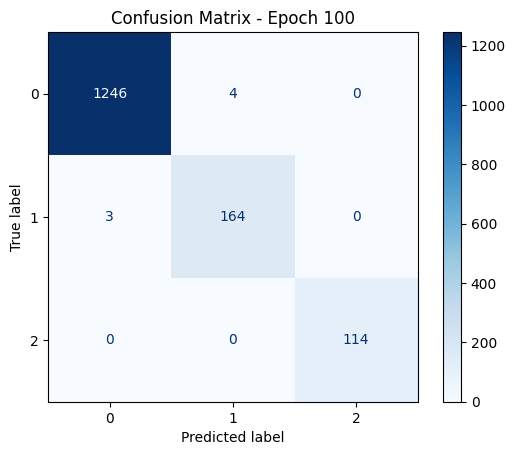

In [83]:
#Training Exp: Model1 ActFun-ReLU Layer-3, lr 0.001
print("Training Exp: Model1 ActFun-ReLU Layer-3, lr 0.001")

input_dim = X_train.shape[1]
hidden_dim = 100
output_dim = len(np.unique(y))  # Number of classes: 3 here (0,1,2)

model = MLP_ReLU1(input_dim, hidden_dim, output_dim)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Increase number of epochs
train_loop(model, train_loader, val_loader, num_epochs)
#save the model
torch.save(model, 'model1_mlp_class_relu_3Layer_lr0_001.pth')

Training Exp: Model2 ActFun-Tanh Layer-5, lr 0.001
Epoch [100/100], Train Loss: 0.0195, Val Loss: 0.0349, Val Accuracy: 0.9922
Accuracy: 0.9922
Precision: 0.9921
Recall: 0.9922
F1 Score: 0.9921
ROC AUC: 0.9997
Confusion Matrix:
[[1248    2    0]
 [   9  158    0]
 [   0    1  113]]


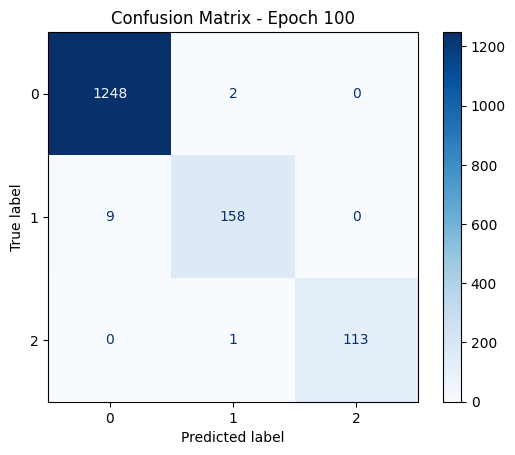

In [84]:
#Training Exp: Model2 ActFun-Tanh Layer-5, lr 0.001
print("Training Exp: Model2 ActFun-Tanh Layer-5, lr 0.001")

input_dim = X_train.shape[1]
hidden_dim = 100
output_dim = len(np.unique(y))  # Number of classes: 3 here (0,1,2)

model = MLP_Tanh(input_dim, hidden_dim, output_dim)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Increase number of epochs
train_loop(model, train_loader, val_loader, num_epochs)
#save the model
torch.save(model, 'model2_mlp_class_tanh_5Layer_lr0_001.pth')




Training Exp: Model3 ActFun-Sigmoid Layer-3, lr 0.0001
Epoch [100/100], Train Loss: 0.0174, Val Loss: 0.0322, Val Accuracy: 0.9928
Accuracy: 0.9928
Precision: 0.9929
Recall: 0.9928
F1 Score: 0.9928
ROC AUC: 0.9985
Confusion Matrix:
[[1244    6    0]
 [   2  165    0]
 [   2    1  111]]


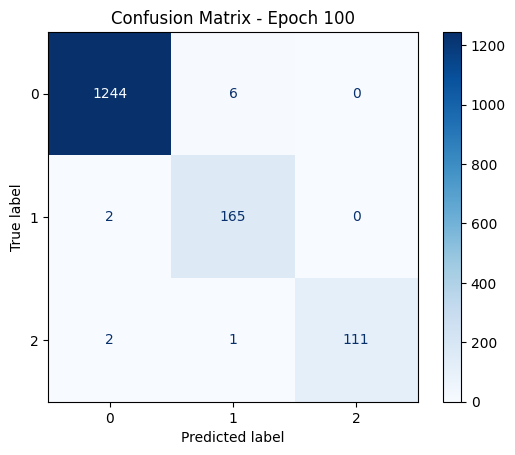

In [85]:
#Training Exp: Model3 ActFun-Sigmoid Layer-3, lr 0.0001
print("Training Exp: Model3 ActFun-Sigmoid Layer-3, lr 0.0001")

input_dim = X_train.shape[1]
hidden_dim = 100
output_dim = len(np.unique(y))  # Number of classes: 3 here (0,1,2)

model = MLP_Sigmoid(input_dim, hidden_dim, output_dim)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100  # Increase number of epochs
train_loop(model, train_loader, val_loader, num_epochs)
#save the model
torch.save(model, 'model3_mlp_class_sigmoid_3Layer_lr0_0001.pth')


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# Load dataset
data = pd.read_csv('/content/sample_data/test_classification.csv')

# Drop columns Date and Time
if 'Date' in data.columns:
    data = data.drop(columns=['Date'])
if 'Time' in data.columns:
    data = data.drop(columns=['Time'])
# Map label 3 to 2 for contiguous class indices before splitting
data['Label'] = data['Label'].replace(3, 2)

# Extract features and target
X = data.drop(columns=['Label']).values  # all except label column
y = data['Label'].values                  # labels already 0,1,3 integers


# keep 90% for test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.9, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to torch tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for batch processing
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=10)

In [90]:
#Eval Exp: Model1 relu_3Layer_lr0_001
model_eval = torch.load('model1_mlp_class_relu_3Layer_lr0_001.pth', weights_only=False)
# Validate the New test data
print(f"Test Classification model 1:relu_3Layer_lr0_001")
num_epochs = 100  # Increase number of epochs
test_loop(model_eval, val_loader, num_epochs)



Test Classification model 1:relu_3Layer_lr0_001
Epoch [100/100], Val Loss: 0.0829, Val Accuracy: 0.9868


In [91]:
#Eval Exp: Model2 relu_5Layer_lr0_001
model_eval = torch.load('model1_mlp_class_relu_3Layer_lr0_001.pth', weights_only=False)
# Validate the New test data
print(f"Test Classification model 2:tanh_5Layer_lr0_001 ")
num_epochs = 100  # Increase number of epochs
test_loop(model_eval, val_loader, num_epochs)


Test Classification model 2:tanh_5Layer_lr0_001 
Epoch [100/100], Val Loss: 0.0829, Val Accuracy: 0.9868


In [ ]:
#Eval Exp: Model3 sigmoid_3Layer_lr0_0001
model_eval = torch.load('model3_mlp_class_sigmoid_3Layer_lr0_0001.pth', weights_only=False)
# Validate the New test data
print(f"Test Classification model 3:sigmoid_3Layer_lr0_0001")
num_epochs = 100  # Increase number of epochs
test_loop(model_eval, val_loader, num_epochs)

Test Classification model 3:sigmoid_3Layer_lr0_0001
